## pipeline

In [1]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error
import h5py

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_2_channel, semantic_segment_crop_and_cat_2_channel_output, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite
from func.unet_3d_basic import UNet3D_basic
from func.utils import save_obj, load_obj

/home/wangad/anaconda3/envs/test/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### init model

In [2]:
#model=UNet3D_basic(in_channels = 1, out_channels = 2)
#load_path=''
#model=VoxResNet(input_channel=1, n_classes=2, output_func = "softmax")
#load_path=''
model=CellSegNet_basic_lite(input_channel=1, n_classes=2, output_func = "softmax")
load_path='output/model_LRP.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model.to(device)

#summary(model, (1, 64, 64, 64))

CellSegNet_basic_lite(
  (conv1): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bnorm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule1): ResModule(
    (batchnorm_module): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule2): ResModule(
    (batchnorm_module): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule3): R

### dataset info

In [3]:
data_dict = load_obj("dataset_info/LRP_dataset_info")
data_dict_test = data_dict["test"]

### seg one img

parameter setting

In [4]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=128
stride=64

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [5]:
print("there are test imgs: "+str(data_dict_test.keys()))
case = 'Movie2_T00010_crop_gt.h5'
print("for test case "+str(case)+" : "+str(data_dict_test[case]))

there are test imgs: dict_keys(['Movie1_t00045_crop_gt.h5', 'Movie2_T00010_crop_gt.h5', 'Movie2_T00020_crop_gt.h5'])
for test case Movie2_T00010_crop_gt.h5 : /data0/wangad/CellSeg_dataset/LateralRootPrimordia_processed/test/Movie2_T00010_crop_gt.h5


In [6]:
hf = h5py.File(data_dict_test[case], 'r')
print(hf.keys())
raw_img = np.array(hf["raw"], dtype=np.float)
hand_seg = np.array(hf["ins"], dtype=np.float)
boundary_gt = np.array(hf["boundary"], dtype=np.float)
background_gt = np.array(hf["background"], dtype=np.float)
foreground_gt = np.array(hf["foreground"], dtype=np.float)

print("raw_img shape: "+str(raw_img.shape))
print("hand_seg shape: "+str(hand_seg.shape))
raw_img_shape = raw_img.shape
hand_seg_shape = hand_seg.shape

<KeysViewHDF5 ['background', 'boundary', 'foreground', 'ins', 'raw']>


/tmp/ipykernel_2255849/738694774.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_img = np.array(hf["raw"], dtype=np.float)
/tmp/ipykernel_2255849/738694774.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hand_seg = np.array(hf["ins"], dtype=np.float)
/tmp/ipykernel_2255849/738694774.py:5: DeprecationWarning: `np.float` is a de

raw_img shape: (201, 225, 795)
hand_seg shape: (201, 225, 795)


feed raw image crops to the model

In [7]:
start = time.time()

transposes = [[0,1,2],[2,0,1],[0,2,1]]#,[1,0,2]]
reverse_transposes = [[0,1,2],[1,2,0],[0,2,1]]#,[1,0,2]]

# feed the raw img to the model
print('Feed raw img to model. Use different transposes')
raw_img_size=raw_img.shape
seg_boundary_comp = np.zeros(raw_img_size)
seg_img_boundary_comp = np.zeros(raw_img_size)
for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    with torch.no_grad():
        seg_img=\
        semantic_segment_crop_and_cat_2_channel_output(raw_img.transpose(transpose), model, device,
                                                       crop_cube_size=crop_cube_size, stride=stride)
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    # probability map to 0 1 segment
    seg_foreground=np.array(seg_img_foreground-seg_img_boundary>0, dtype=np.int)
    seg_boundary=1 - seg_foreground
        
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
    seg_img_foreground=seg_img_foreground.transpose(reverse_transposes[idx])
    seg_img_boundary=seg_img_boundary.transpose(reverse_transposes[idx])
    
    seg_boundary_comp+=seg_boundary
    seg_img_boundary_comp+=seg_img_boundary

print("Get model semantic seg by combination")
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=np.int)
seg_foreground_comp = 1 - seg_boundary_comp

end = time.time()

print("Time elapsed: ", end - start)

Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]


/tmp/ipykernel_2255849/3857266437.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_foreground=np.array(seg_img_foreground-seg_img_boundary>0, dtype=np.int)


2: Transpose the image to be: [2, 0, 1]
3: Transpose the image to be: [0, 2, 1]
Get model semantic seg by combination


/tmp/ipykernel_2255849/3857266437.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=np.int)


Time elapsed:  2283.0522305965424


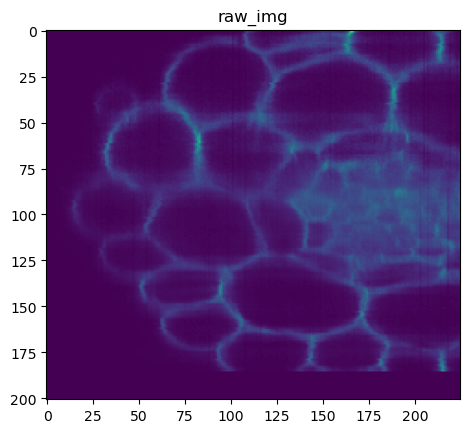

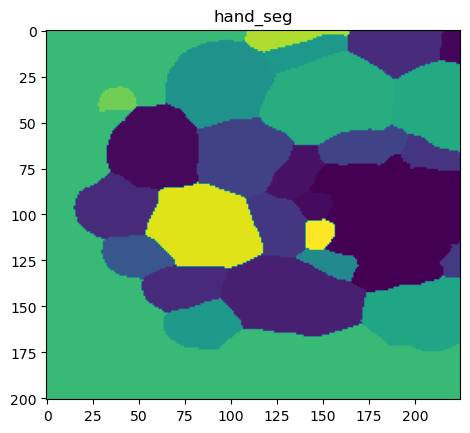

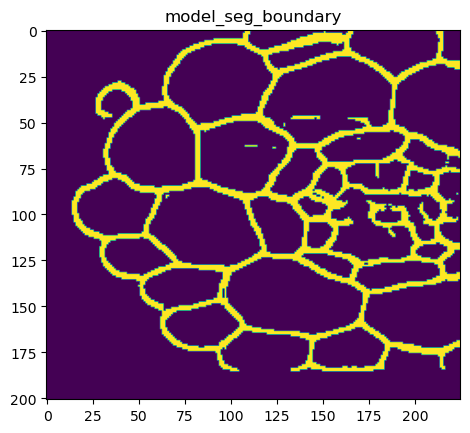

In [8]:
# show current result

N=200

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[:,:,N])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[:,:,N])

TASCAN

generate super vox by watershed

In [9]:
# Generate super vox by watershed
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion)
# from skimage.measure import label
# from skimage.segmentation import join_segmentations, watershed
# from skimage.feature import peak_local_max
# seg_foreground_edt=edt.edt(np.array(seg_foreground_erosion, dtype=np.uint32, order='F'),
#                            black_border=True, order='F',parallel=1)
# min_distance_between_cells = 5
# coords = peak_local_max(seg_foreground_edt, min_distance=min_distance_between_cells,
#                         labels=np.array(seg_foreground_erosion>0))
# mask = np.zeros(seg_foreground_edt.shape, dtype=bool)
# mask[tuple(coords.T)] = True
# markers = label(mask==True)
# seg_foreground_super_voxel_by_ws = watershed(-seg_foreground_edt, markers=markers, mask=np.array(seg_foreground_comp>0), connectivity=min_touching_area)

In [10]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 11967 super voxels


super voxel clustearing

In [11]:
#Super voxel clustering
cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
cluster_super_vox.fit(copy.deepcopy(seg_foreground_super_voxel_by_ws))
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

valid_neighbor_vals: [ 4728  4729  4780  6633  6894  6925  6926  6927  6986  7096  7177  7370
  7682  8392  9092  9093  9094  9095  9096  9097  9098  9099  9120  9121
  9125  9127  9128  9138  9148  9875 10462 10486 10499 11581 11601 11607
Assign label 8592 to current val's neighbors: [ 4728  4729  4780  6633  6894  6925  6926  6927  6986  7096  7177  7370
  7682  8392  9092  9093  9094  9095  9096  9097  9098  9099  9120  9121
  9125  9127  9128  9138  9148  9875 10462 10486 10499 11581 11601 11607
valid_neighbor_vals: [ 2457  2495  2496  3834  4118  4311  4364  4567  4568  4569  4570  4639
  4640  4689  6073  6074  6161  6162  6163  6404  6406  6568  6630  6631
  6632  6713  6714  6716  6794  6852  6924  8225  8264  8323  8324  8325
  8566  8758  8777  8778  9119  9122  9124  9126  9129  9130  9131  9132
  9133  9134  9135  9136  9137  9139  9140  9142  9145  9149  9150  9151
  9157  9474  9706 10092 10095 10108 10109 10288 10290 10299 10301 10302
 10425 10456 10461 10465 10467 10469

delete too small cells

In [12]:
# Delete too small cells
min_cell_size_threshold=10
seg_foreground_single_cell_with_boundary = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [13]:
# Assign boudary voxels to their nearest cells
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary, seg_boundary_comp, compactness=1)

see the final result

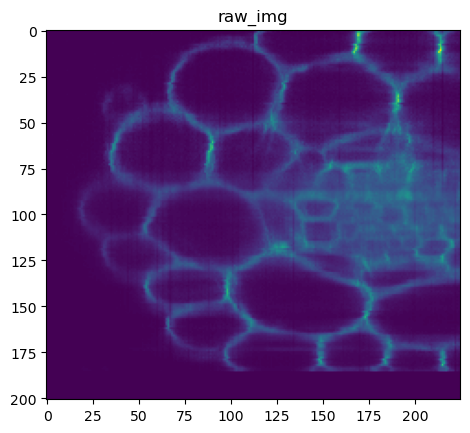

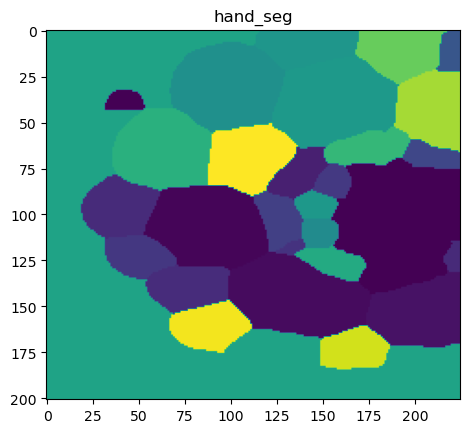

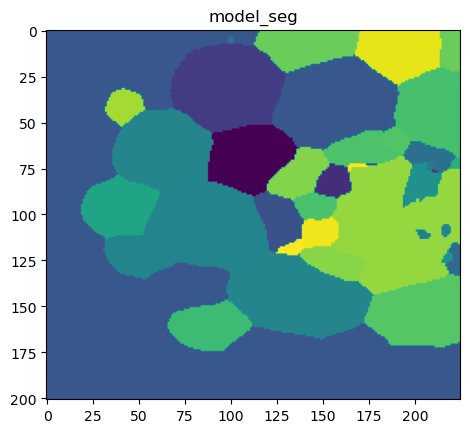

In [14]:
N=250
#print("There are "+str(len(np.unique(seg_foreground_single_cell_with_boundary)))+" cells")
plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[:,:,N])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.title("model_seg")
plt.imshow(reassign(seg_final[:,:,N]))

In [15]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB

In [16]:
seg_final_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

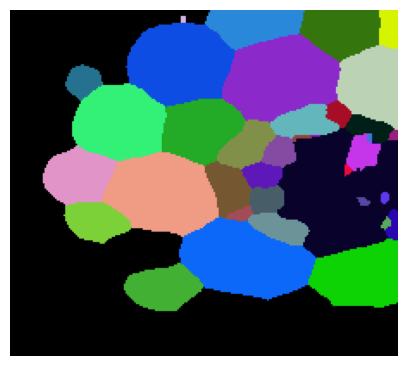

In [17]:
N=250

fig = plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(seg_final_RGB[:,:,N],cmap="gray")
#plt.savefig('seg_final_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

calculate accuracy

In [18]:
unique_vals, counts = np.unique(seg_final, return_counts=True)
locs = np.argsort(counts)
hand_seg_revise = copy.deepcopy(hand_seg)
hand_seg_revise[seg_final==unique_vals[locs[::-1]][0]]=0

In [19]:
ARI = adjusted_rand_score(hand_seg_revise.flatten(), seg_final.flatten())
ARE = adapted_rand_error(hand_seg_revise.astype(np.int).flatten(), seg_final.astype(np.int).flatten())
VOI_val = VOI(seg_final.astype(np.int),hand_seg_revise.astype(np.int))

/tmp/ipykernel_2255849/677926285.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ARE = adapted_rand_error(hand_seg_revise.astype(np.int).flatten(), seg_final.astype(np.int).flatten())
/tmp/ipykernel_2255849/677926285.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

In [20]:
print("ARI: "+str(ARI))
print("ARE: "+str(ARE))
print("VOI: "+str(VOI_val))

ARI: 0.8332058180596854
ARE: (0.03746398205688206, 0.9624931648548799, 0.9625788748474222)
VOI: (0.3532713409931783, 0.22532474958235005)


In [21]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

scale_factor = 0.4
org_shape = seg_final.shape
output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
print(str(org_shape)+" --> "+str(output_size))

(201, 225, 795) --> (80, 90, 318)


In [22]:
accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg_revise, output_size = output_size), img_3d_interpolate(seg_final, output_size = output_size))
accuracy_record=accuracy.cal_accuracy_II()

iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

print('avg iou: '+str(np.mean(accuracy_record[:,1])))
print('avg dice: '+str(np.mean(accuracy_record[:,2])))

cell count accuracy iou >0.7: 0.7261904761904762
cell count accuracy dice >0.7: 0.7738095238095238
cell count accuracy iou >0.5: 0.7976190476190477
cell count accuracy dice >0.5: 0.8571428571428571
avg iou: 0.7521143749675373
avg dice: 0.8084800206585593


/tmp/ipykernel_2255849/576851890.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/tmp/ipykernel_2255849/576851890.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
/tmp/ipykernel_2255849/576851890.py:10: DeprecationWarning: